# Exponential Smoothing, Holt-Winters, N-Beats

Libraries and Data

In [1]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# import csv dataset
df=pd.read_csv('divvy-tripdata_cleaned.csv',index_col='start_time',parse_dates=True)

# make into dataframe
df2=pd.DataFrame(df)

# which columns to include alongside column acting as index
cols=[3]
df2=df2[df2.columns[cols]]

In [3]:
# sorting the dataframe
df3=df2.sort_values("start_time")
df4=df3
df3.head()

,trip_duration
start_time,
2013-06-30 10:48:00,557
2013-06-30 10:51:00,12496
2013-06-30 11:27:00,699
2013-06-30 11:35:00,1093
2013-06-30 11:56:00,3957


In [4]:
# index
# df3=df3.asfreq("T")
# df3.index

Model: Exponential Smoothing

In [5]:
model = ExponentialSmoothing(endog = df3.trip_duration).fit()

C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Predictions and Plotting: Exponential Smoothing

In [6]:
predictions=model.forecast(steps=100)

C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:xlabel='start_time'>

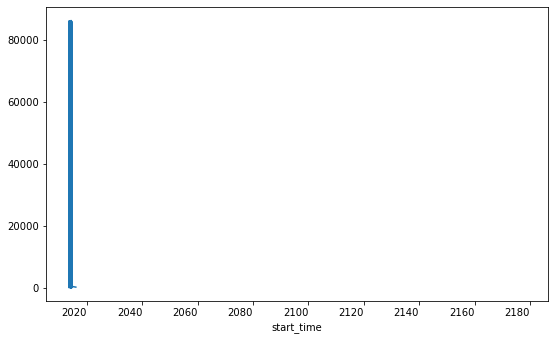

In [7]:
df3['trip_duration'].plot(figsize=(9,6))
predictions.plot()

Model: Holt-Winters

In [8]:
model2=ExponentialSmoothing(endog=df3.trip_duration, 
                            trend='add', 
                            seasonal='add', 
                            seasonal_periods=7).fit()

C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Predictions and Plotting: Holt-Winters

In [9]:
predictions2=model2.forecast(steps=100)

C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:xlabel='start_time'>

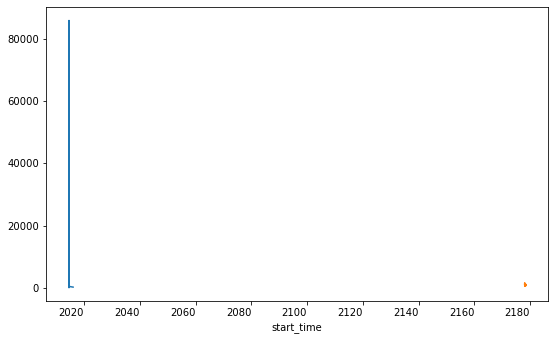

In [10]:
df3['trip_duration']['2014-06-30 10:51:00':].plot(figsize=(9,6))
predictions2.plot()

N-Beats

In [11]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('temp.csv')

In [13]:
df.head()

,month,trip_duration
0,2011-01,112
1,2011-02,118
2,2011-03,132
3,2011-04,129
4,2011-05,121


In [14]:
series = TimeSeries.from_dataframe(df, time_col='month')

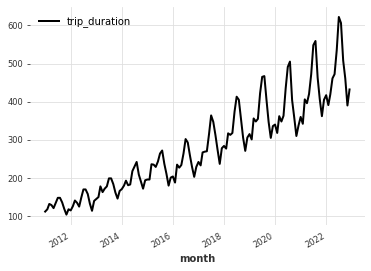

In [15]:
series.plot()

In [16]:
from darts.utils.statistics import check_seasonality

is_daily_seasonal, daily_period = check_seasonality(series, m=24, max_lag=400, alpha=0.05)
is_weekly_seasonal, weekly_period = check_seasonality(series, m=168, max_lag=400, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')

Daily seasonality: True - period = 24
Weekly seasonality: False - period = 168


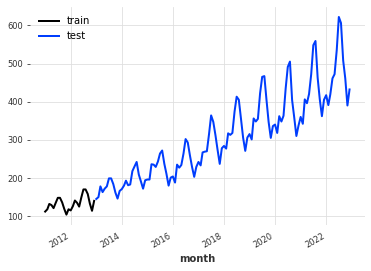

In [17]:
train, test = series[:-120], series[-120:]

train.plot(label='train')
test.plot(label='test')

In [18]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=6)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(3)

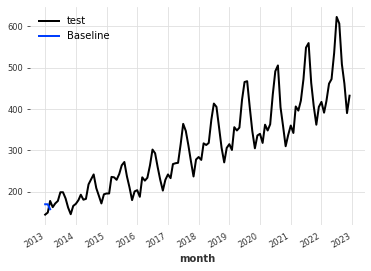

In [19]:
test.plot(label='test')
pred_naive.plot(label='Baseline')

In [20]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)

print(naive_mae)

21.666666666666668


In [21]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

In [22]:
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

In [23]:
nbeats = NBEATSModel(
    input_chunk_length=6, 
    output_chunk_length=3,
    generic_architecture=True,
    random_state=4)

In [24]:
nbeats.fit(
    scaled_train,
    epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.3 K     Non-trainable params
6.1 M     Total params
48.430    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

RuntimeError: Numpy is not available

In [ ]:
scaled_pred_nbeats = nbeats.predict(n=5)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

In [ ]:
mae_nbeats = mae(test, pred_nbeats)

print(mae_nbeats)

In [ ]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = concatenate(
    [dt_attr(series.time_index, 'day', dtype=np.float32), dt_attr(series.time_index, 'week', dtype=np.float32)],
    axis='component'
)

In [ ]:
cov_scaler = Scaler()
scaled_cov = cov_scaler.fit_transform(cov)

In [ ]:
nbeats_cov = NBEATSModel(
    input_chunk_length=168, 
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

nbeats_cov.fit(
    scaled_train,
    past_covariates=scaled_cov,
    epochs=50
)

In [ ]:
scaled_pred_nbeats_cov = nbeats_cov.predict(past_covariates=scaled_cov, n=120)

pred_nbeats_cov = train_scaler.inverse_transform(scaled_pred_nbeats_cov)

In [ ]:
test.plot(label='test')
pred_nbeats.plot(label='N-BEATS')

In [ ]:
mae_nbeats_cov = mae(test, pred_nbeats_cov)

print(mae_nbeats_cov)